# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se 
- o cálculo do gradiente automático do PyTorch, porém 
- a função de perda e 
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [ ]:
# http://pytorch.org/
from os.path import exists
#!pip install numpy==1.15.0
!pip install -q install wheel==0.34.2 setuptools

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
print(get_abbr_impl())
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#https://download.pytorch.org/whl/cpu/torch-0.4.1.post2-cp37-cp37m-linux_x86_64.whl
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post2-{platform}-linux_x86_64.whl torchvision
import torch

ERROR: tensorflow 2.5.0 has requirement wheel~=0.35, but you'll have wheel 0.34.2 which is incompatible.
cp
     |████████████████████████████████| 89.4MB 1.2MB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 0.4.1.post2 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 0.4.1.post2 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1.post2 which is incompatible.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim
from torch.autograd import Variable

torch.manual_seed(1234)

## Leitura dos dados

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [ ]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [ ]:
print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train[:5]:
 [[1.        ]
 [0.71428573]
 [0.952381  ]
 [0.28571424]
 [0.7619048 ]]
y_train[:5]:
 [[0.80952376]
 [0.71428573]
 [0.90476197]
 [0.4761905 ]
 [0.7619048 ]]


In [ ]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [ ]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428573],
       [1.        , 0.95238101],
       [1.        , 0.28571424],
       [1.        , 0.76190478],
       [1.        , 0.38095227],
       [1.        , 0.66666675],
       [1.        , 0.        ],
       [1.        , 0.80952376],
       [1.        , 0.14285702],
       [1.        , 0.047619  ],
       [1.        , 0.47619051],
       [1.        , 0.52380949],
       [1.        , 0.57142848],
       [1.        , 0.33333325],
       [1.        , 0.85714275],
       [1.        , 0.33333325],
       [1.        , 0.42857149],
       [1.        , 0.61904752],
       [1.        , 0.33333325],
       [1.        , 0.47619051],
       [1.        , 0.57142848],
       [1.        , 0.66666675],
       [1.        , 0.57142848],
       [1.        , 0.71428573],
       [1.        , 0.80952376],
       [1.        , 0.90476197],
       [1.        , 0.85714275],
       [1.        , 0.52380949],
       [1.        , 0.38095227],
       [1.

In [ ]:
print('x_train_bias.shape:',x_train_bias.shape, x_train_bias.dtype)

x_train_bias.shape: (50, 2) float64


In [ ]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)
print(y_train)

tensor([[0.8095],
        [0.7143],
        [0.9048],
        [0.4762],
        [0.7619],
        [0.7143],
        [0.8095],
        [0.1429],
        [0.7619],
        [0.4286],
        [0.2381],
        [0.5714],
        [0.4762],
        [0.8095],
        [0.2857],
        [0.6667],
        [0.7143],
        [0.5238],
        [0.7143],
        [0.4286],
        [0.8571],
        [0.4762],
        [0.9048],
        [0.8095],
        [0.6190],
        [0.6667],
        [0.8571],
        [0.9524],
        [0.7143],
        [0.2381],
        [0.3810],
        [0.3333],
        [0.4286],
        [1.0000],
        [0.7143],
        [0.7143],
        [0.8095],
        [0.6667],
        [0.5238],
        [0.4762],
        [0.6667],
        [0.7619],
        [0.4762],
        [0.1429],
        [0.5714],
        [0.5714],
        [0.5714],
        [0.6190],
        [0.0000],
        [0.5238]])


## Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

In [ ]:
model = torch.nn.Linear(in_features=2, out_features=1, bias=False)

### Verificando a inicialização dos parâmetros

In [ ]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  


Parameter containing:
tensor([[0.0550, 0.0642]], requires_grad=True)

### Testando o predict da rede

In [ ]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [ ]:
model(Variable(xx))

tensor([[0.1191],
        [0.1191],
        [0.1191],
        [0.1191],
        [0.1191]], grad_fn=<MmBackward>)

## Treinamento

In [ ]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    out = model(inputs)

    #loss cálculo da função de perda
    loss = torch.pow(out - target, 2).mean()
    print('loss:',loss.data.numpy())
    
    # backward propagation - cálculo gradiente
    loss.backward()
    
    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data
    
    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data[0]))

loss: 0.30765486
loss: 0.04818705
loss: 0.030492134
loss: 0.028641427
loss: 0.027888542
loss: 0.027265498
loss: 0.026703794
loss: 0.02619407
loss: 0.025731303
loss: 0.025311165
loss: 0.024929719
loss: 0.0245834
loss: 0.024268983
loss: 0.023983516
loss: 0.023724344
loss: 0.02348904
loss: 0.023275403
loss: 0.02308145
loss: 0.022905352
loss: 0.02274548
Epoch[20/100], loss: 0.022745
loss: 0.022600327
loss: 0.022468545
loss: 0.022348898
loss: 0.022240274
loss: 0.022141647
loss: 0.022052107
loss: 0.021970814
loss: 0.021897009
loss: 0.021829998
loss: 0.021769157
loss: 0.021713924
loss: 0.021663778
loss: 0.021618247
loss: 0.02157691
loss: 0.02153938
loss: 0.021505307
loss: 0.021474378
loss: 0.02144629
loss: 0.021420792
loss: 0.02139764
Epoch[40/100], loss: 0.021398
loss: 0.021376621
loss: 0.021357538
loss: 0.021340216
loss: 0.021324484
loss: 0.021310205
loss: 0.021297235
loss: 0.021285467
loss: 0.021274777
loss: 0.021265075
loss: 0.021256268
loss: 0.021248266
loss: 0.021241007
loss: 0.02123441

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


## Avaliação

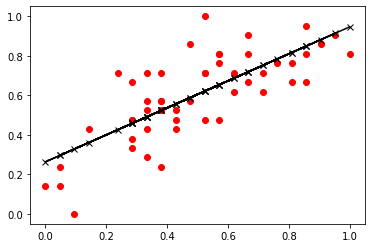

In [ ]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [ ]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2630, 0.6832]]))])

### Parâmetros ótimos, solução analítica

In [ ]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data[0]`? Por que precisa do `data` e por que precisa da indexação por zero?
   

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação 
   dos parâmetros do modelo duas dimensões. 
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

## Ploting vectors

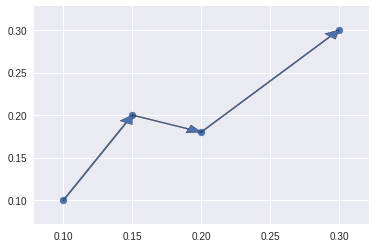

In [ ]:
# Exemplo
w0_list = [0.1, 0.15, 0.2, 0.3]
w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1


# Aprendizados